In [156]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


In [157]:
# Define path and parameters
test_dir = r'C:\Users\LENOVO\Downloads\IDP\IDP\Cotton Disease\test'  
img_size = (224, 224)  # Common for VGG, ResNet. 
batch_size = 32


In [158]:
# Generator for VGG and ResNet (224x224)
test_datagen_224 = ImageDataGenerator(rescale=1./255)

test_generator_224 = test_datagen_224.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 106 images belonging to 4 classes.


In [159]:
vgg_model = load_model(r'C:\Users\LENOVO\Downloads\IDP\vgg_model (1).h5')
resnet_model = load_model(r'C:\Users\LENOVO\Downloads\IDP\IDP\Cotton Disease\resnet50_cotton_disease_model.h5')
inception_model = load_model(r'C:\Users\LENOVO\Downloads\IDP\inception_cotton_model.h5')


In [160]:
# Use test_generator_224 for ALL THREE MODELS since they expect (224, 224, 3)
vgg_probs = vgg_model.predict(test_generator_224)
resnet_probs = resnet_model.predict(test_generator_224)
inception_probs = inception_model.predict(test_generator_224)




4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step 


In [161]:
# Convert probabilities to class predictions
vgg_preds = np.argmax(vgg_probs, axis=1)
resnet_preds = np.argmax(resnet_probs, axis=1)
inception_preds = np.argmax(inception_probs, axis=1)

# Print the shapes
print("Shape of VGG Predictions:", vgg_preds.shape)
print("Shape of ResNet Predictions:", resnet_preds.shape)
print("Shape of Inception Predictions:", inception_preds.shape)



Shape of VGG Predictions: (106,)
Shape of ResNet Predictions: (106,)
Shape of Inception Predictions: (106,)


In [167]:
for i in range(5):
    print(f"Sample {i+1}")
    print("VGG Prediction:", class_labels[vgg_preds[i]], " | Probabilities:", vgg_probs[i])
    print("ResNet Prediction:", class_labels[resnet_preds[i]], " | Probabilities:", resnet_probs[i])
    print("Inception Prediction:", class_labels[inception_preds[i]], " | Probabilities:", inception_probs[i])
    print("------")


Sample 1
VGG Prediction: diseased cotton leaf  | Probabilities: [9.9998689e-01 1.7241498e-06 1.0408889e-05 9.9938995e-07]
ResNet Prediction: diseased cotton plant  | Probabilities: [0.14341983 0.49082285 0.12250282 0.24325451]
Inception Prediction: diseased cotton leaf  | Probabilities: [9.9999893e-01 1.5564490e-07 9.6424242e-07 1.2240537e-08]
------
Sample 2
VGG Prediction: diseased cotton leaf  | Probabilities: [9.9992323e-01 5.0653292e-05 2.5605121e-05 4.8567233e-07]
ResNet Prediction: diseased cotton plant  | Probabilities: [0.18235368 0.34550118 0.24445128 0.22769384]
Inception Prediction: diseased cotton leaf  | Probabilities: [9.9999702e-01 7.3958040e-07 2.2945910e-06 2.3495053e-08]
------
Sample 3
VGG Prediction: diseased cotton leaf  | Probabilities: [9.9945790e-01 6.1272573e-08 5.4185156e-04 1.2943846e-07]
ResNet Prediction: diseased cotton plant  | Probabilities: [0.08004175 0.38231578 0.29208896 0.24555343]
Inception Prediction: diseased cotton leaf  | Probabilities: [9.999

training meta model

In [168]:
X_val = val_generator_224



In [169]:
pred_resnet = resnet_model.predict(X_val)
pred_vgg = vgg_model.predict(X_val)

X_meta = np.concatenate([pred_resnet, pred_vgg], axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step


In [170]:
print("Shape of X_meta (ResNet + VGG):", X_meta.shape)


Shape of X_meta (ResNet + VGG): (253, 8)


In [171]:
X_val = np.concatenate([pred_vgg, pred_resnet], axis=1)

In [172]:
print("X_meta shape:", X_meta.shape)
print("y_val shape:", y_val.shape)


X_meta shape: (253, 8)
y_val shape: (253,)


In [173]:
from tensorflow.keras.utils import to_categorical

# You have 4 classes
num_classes = 4

# Convert y_val (which is probably in integer form like [0, 1, 2, 3]) into one-hot encoding
y_meta = to_categorical(y_val, num_classes)


In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization

num_classes = 4  # Assuming 4 output classes
input_features = 2 * num_classes  # Assuming stacking from 2 base models

meta_model = Sequential([
    Input(shape=(input_features,)),       # e.g., 8 input features from two base models
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # Output layer for classification
])


In [175]:
meta_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [176]:
history = meta_model.fit(X_meta, y_meta, epochs=50, batch_size=32)



Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4216 - loss: 1.5878
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9208 - loss: 0.3103 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9279 - loss: 0.2696 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9410 - loss: 0.2276 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9376 - loss: 0.2229 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9480 - loss: 0.1942 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9347 - loss: 0.2599 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9349 - loss: 0.1695 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9631 - loss: 0.2378 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9559 - loss: 0.1609 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9272 - loss: 0.3099 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9313 - loss: 0.1545 
Ep

In [177]:
meta_model.save("_meta_modelf.h5")

In [178]:


# Define the path to your test set
test_data_path = r'C:\Users\LENOVO\Downloads\IDP\IDP\Cotton Disease\test'  

# Create an ImageDataGenerator instance for test data (just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the directory and create a generator
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224), 
    batch_size=32,  
    class_mode='categorical',  
    shuffle=False  
)

# Get predictions from the base models (ResNet and VGG)
pred_resnet_test = resnet_model.predict(test_generator, verbose=1)
pred_vgg_test = vgg_model.predict(test_generator, verbose=1)

# Stack the predictions from both models (ResNet and VGG)
predictions_combined = np.hstack((pred_resnet_test, pred_vgg_test))

# Get the true labels from the test generator
y_test = test_generator.labels

# Ensure both predictions and labels have the same shape (check number of classes)
print(f'Predictions shape: {predictions_combined.shape}')
print(f'Labels shape: {y_test.shape}')

Found 106 images belonging to 4 classes.


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
Predictions shape: (106, 8)
Labels shape: (106,)


In [179]:
from tensorflow.keras.utils import to_categorical

# Assuming y_test is the true labels from your test set
# If y_test is not one-hot encoded, we need to convert it
if len(y_test.shape) == 1:  # If y_test is 1D (not one-hot encoded)
    y_test = to_categorical(y_test, num_classes=4)

In [180]:
assert predictions_combined.shape[1] == 8, \
    f"Predictions should have 8 features, but got {predictions_combined.shape[1]}"

In [181]:
meta_model_score = meta_model.evaluate(predictions_combined, y_test)

print(f'Meta-model Evaluation Score: {meta_model_score}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9793 - loss: 0.2219  
Meta-model Evaluation Score: [0.2415659874677658, 0.9716981053352356]


In [182]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

# Evaluate the meta-model on the test set
meta_model_score = meta_model.evaluate(predictions_combined, y_test)

# Extract accuracy from the evaluation results
loss, accuracy = meta_model_score  # meta_model_score is a list with [loss, accuracy]

# Make predictions using the meta-model
predictions_meta_model = meta_model.predict(predictions_combined)

# Get the predicted class labels by taking the argmax (as the output is one-hot encoded)
predicted_classes = np.argmax(predictions_meta_model, axis=1)
true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to class labels

# Calculate precision, recall, and F1 score (use average='weighted' for multi-class)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

# Print evaluation results
print(f'Meta-model Evaluation Score: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9793 - loss: 0.2219 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Meta-model Evaluation Score: Loss = 0.2416, Accuracy = 0.9717
Precision: 0.9727
Recall: 0.9717


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


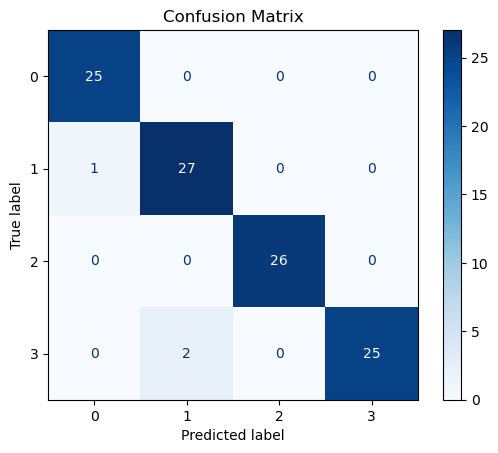

In [183]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get the predicted class labels from the meta-model
predictions_meta_model = meta_model.predict(predictions_combined)

# Convert predictions to class labels (argmax to get the class with highest probability)
predicted_classes = np.argmax(predictions_meta_model, axis=1)

# Convert true labels from one-hot encoding to class labels
true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))

# Plot the confusion matrix
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [184]:
print(history.history.keys())


dict_keys(['accuracy', 'loss'])


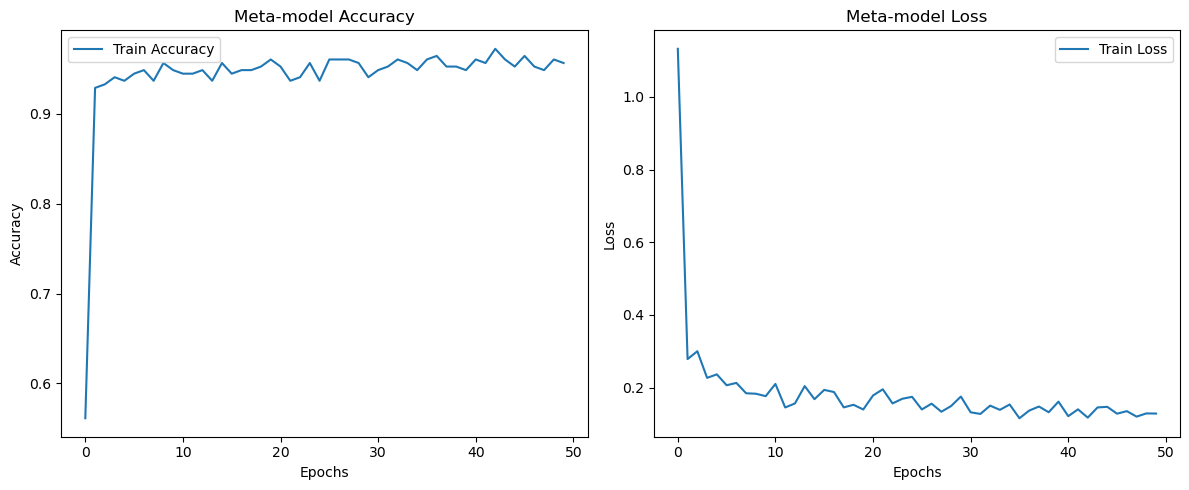

In [185]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Meta-model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Meta-model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


